# PRÁCTICA 7.1. MODELOS DE DIFUSIÓN

En esta práctica vamos a construir y entrenar un Modelo Probabilístico de Difusión de Eliminación de Ruido (DDPM). A diferencia de las redes que hemos visto antes (que clasifican imágenes o localizan un objeto), este modelo es generativo: aprende a crear imágenes nuevas desde cero. Es la misma tecnología base que usan modelos famosos como **DALL-E 3** o **Stable Diffusion**.

## 0. Objetivos
* Entrenar una red neuronal que aprenda a transformar "ruido de televisión" (aleatorio) en imágenes de ropa (FashionMNIST).
* Usar la librería diffusers de Hugging Face.
* Usar la librería tqdm para mostrar un mejor progreso del entrenamiento.

## 1. Instalación

Necesitamos la librería `diffusers` de Hugging Face, que contiene los bloques de construcción modernos para difusión. Con la siguiente línea podrás instalarlo.

In [ ]:
# Instalamos la librería diffusers y accelerate (para optimizar el entrenamiento)
!pip install diffusers accelerate tqdm -q

Vamos a importar de la libería diffusers dos módulos:
* `DDPMScheduler`: gestiona la agenda de ruido (schedule), definiendo exactamente cuánto ruido se inyecta a la imagen en cada paso del entrenamiento para destruirla progresivamente, y proporcionando las fórmulas precisas para invertir ese proceso durante la generación, guiando a la red neuronal para que elimine el ruido de forma controlada paso a paso hasta recuperar una imagen nítida.
* `UNet2DModel`: UNet es un tipo especial de autoencoder. Se ha utilizado principalmente en segmentación de imágenes médicas, y ahora se emplea como parte de los modelos de difusión.

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Hiperparámetros
IMG_SIZE = 28  # FashionMNIST es 28x28
BATCH_SIZE = 64
EPOCHS = 3     # Con 3 épocas ya veremos resultados. Para calidad alta, usar 10-20.
LR = 1e-4

2025-12-02 11:39:11.298228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Usando dispositivo: cuda


## 2. Preparar los Datos (FashionMNIST)

Los modelos de difusión esperan que las imágenes estén normalizadas típicamente entre -1 y 1. Esto es por tanto lo que vamos a hacer con la transformación de normalización. Esta vez vamos a usar FashionMNIST para entrenar el modelo de difusión.

100%|██████████| 26421880/26421880 [00:14<00:00, 1785790.00it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 663761.74it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5009526.09it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4355916.28it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



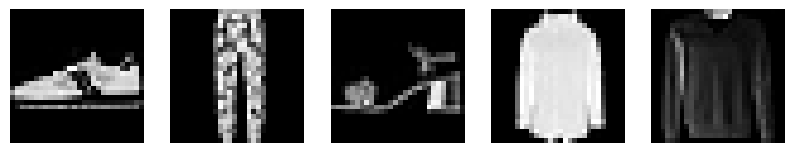

In [4]:
# Transformación: Imagen -> Tensor -> Normalizar [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(), # Convierte a [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # (x - 0.5) / 0.5 -> rango [-1, 1]
])

# Descargar dataset
dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Visualizar algunos ejemplos
images, labels = next(iter(dataloader))
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Des-normalizar para mostrar: (-1, 1) -> (0, 1)
    img = (images[i] / 2 + 0.5).permute(1, 2, 0).numpy()
    plt.imshow(img, cmap="gray")
    plt.axis('off')
plt.show()

## 3. El Proceso de Difusión (Forward Process)

Un modelo de difusión funciona aprendiendo a deshacer el ruido. Comenzando con una imagen del dataset, en cada instante de tiempo $t$, el proceso de difusión añade ruido gausiano con media 0 y varianza $\beta_t$. El modelo se entrena para revertir este proceso. En concreto el modelo predice el ruido total que se añadió a la imagen original hasta el instante $t$. Es decir, no tenemos un modelo para cada paso, sino uno para todos. En el [paper DDPM](https://arxiv.org/abs/2006.11239) se propuso incrementar la varianza $\beta_t$ en cada paso, de $\beta_1 = 0,0001$ a $\beta_T = 0,02$ (siendo $T$ el máximo de pasos). Esta es la combinación que usaremos aquí. 

El ruido se añade a la imagen mediante el denominado **"Forward Diffusion Process"**. Esto lo podemos hacer fácilmente haciendo uso de un DDPMScheduler (planificador). Este define cuánto ruido añadir en cada paso de tiempo:

* Paso 0: Imagen limpia.
* Paso 1000: Ruido puro (Gaussiano).


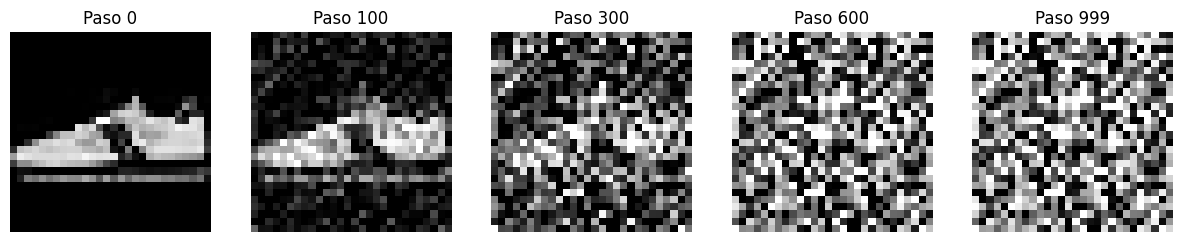

In [5]:
# Creamos el Scheduler
# 'num_train_timesteps=1000' significa que dividimos el proceso de destrucción en 1000 pasos.
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02)

# --- DEMOSTRACIÓN VISUAL ---
# Tomamos una imagen limpia
sample_image = images[0].unsqueeze(0) # Añadir dimensión de batch -> [1, 1, 28, 28]
noise = torch.randn_like(sample_image) # Ruido aleatorio del mismo tamaño

plt.figure(figsize=(15, 3))
pasos_demo = [0, 100, 300, 600, 999]

for i, t in enumerate(pasos_demo):
    if t == 0:
        noisy_im = sample_image
    else:
        # El scheduler añade el ruido correspondiente al paso 't'
        timesteps = torch.LongTensor([t])
        noisy_im = noise_scheduler.add_noise(sample_image, noise, timesteps)
    
    plt.subplot(1, 5, i+1)
    img_show = (noisy_im[0] / 2 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()
    plt.imshow(img_show, cmap="gray")
    plt.title(f"Paso {t}")
    plt.axis("off")
plt.show()

## 4. La Red Neuronal (UNet)

Los modelos de difusión no aprenden a restar ruido gradualmente, sino que aprenden a restar el ruido en un instante *t*. Por ello, necesitamos un modelo que reciba una *imagen con ruido* y un *número de paso (t)*, y prediga cuánto ruido tiene esa imagen. Si sabemos el ruido, podemos restarlo. 

Para esta tarea, los modelos de difusión se basan principalmente en **UNet**. Como se mencionó antes, es un autoencoder con una arquitectura que tiene forma de "U" (baja resolución y luego sube resolución). Gracias a sus *skip connections* que unen las capas de compresión con las de reconstrucción, la red no pierde los detalles espaciales finos, lo que le permite cumplir su misión: predecir exactamente qué parte de la imagen de entrada es ruido puro para que el scheduler pueda restarlo y recuperar poco a poco la estructura original. 

En la U-Net original (la de 2015, con aplicaciones en medicina), cada "escalón" (bloque) de la red eran simplemente dos capas convolucionales seguidas (Conv -> ReLU -> Conv -> ReLU). Sin embargo, en los modelos de difusión modernos, esos bloques simples se sustituyen por Bloques Residuales (ResNet Blocks). Cuando en el código siguiente ponemos `layers_per_block=2` Significa que en cada nivel de resolución (por ejemplo, cuando la imagen está en 16x16), la red aplicará 2 Bloques ResNet consecutivos antes de reducir el tamaño a 8x8. El bloque ResNet ayuda a entrenar redes profundas sin perder información. En lugar de solo transformar la imagen ($x \to f(x)$), un bloque residual suma la entrada original a la salida: $x \to x + f(x)$. Esto crea una skip connection interna para que el gradiente fluya mejor durante el entrenamiento. 

Por otro lado, también se combinan con bloques de atención. En el código de abajo verás `DownBlock2D` (bloque normal) y `AttnDownBlock2D` (bloque con atención). Mezclamos convoluciones y atención puesto que las Convoluciones (Conv2D) son "miopes": Una convolución solo mira un trocito pequeño de la imagen (su ventana de 3x3 píxeles), siendo perfecto para detectar bordes, texturas y formas locales, pero le cuesta entender relaciones lejanas. Por ejemplo: "Si hay un ojo en la esquina superior izquierda, debería haber una boca en el centro". La convolución no ve esa distancia fácilmente, sin embargo, la Atención es "global". Aquí entra la Autoatención Espacial (Spatial Self-Attention), que es el mismo mecanismo matemático que en los Transformers ($Softmax(QK^T)V$), pero aplicado a píxeles en lugar de palabras: El píxel de la esquina superior atiende a todos los demás píxeles de la imagen simultáneamente para entender la estructura global. Por tanto, la red aplica convoluciones (ResNet) para extraer rasgos y luego aplica una capa de Self-Attention para entender el contexto global. 

![](img/unet-difusion.png)

In [6]:
# Creamos el modelo
model = UNet2DModel(
    sample_size=IMG_SIZE,  # 28x28
    in_channels=1,         # 1 canal (Blanco y Negro)
    out_channels=1,        # Salida: el ruido predicho (1 canal)
    layers_per_block=2,    # Capas ResNet por bloque
    block_out_channels=(32, 64, 64), # Número de canales en cada bloque (pequeño para que sea rápido)
    down_block_types=(
        "DownBlock2D",     # Bloque de bajada normal
        "AttnDownBlock2D", # Bloque con atención (aprende formas globales)
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",       # Bloque de subida normal
    ),
)

model.to(device);
print("Modelo cargado en:", device)

Modelo cargado en: cuda


## 5. Entrenamiento

Ahora viene el bucle de entrenamiento. Usaremos como función de pérdida el error cuadrático medio (ya que estamos en un problema de regresión, la salida son númericas), y como optimizador AdamW. 

En cada iteración del bucle hacemos lo siguiente:

* Tomamos imágenes limpias.
* Generamos ruido aleatorio.
* Elegimos un paso de tiempo al azar para cada imagen.
* Añadimos el ruido a las imágenes (Forward).
* La red intenta adivinar qué ruido se añadió.
* Calculamos el error (MSE) entre el ruido real y el ruido predicho.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

#EPOCHS=10

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    # Usamos tqdm para que el bucle de entrenamiento tenga una barra de progreso
    # Es tan fácil como encapsular el iterador (dataloader en nuestro caso) e
    # indicar qué mensaje mostrar al principio de la barra
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch_images, _ in progress_bar:
        clean_images = batch_images.to(device)
        bs = clean_images.shape[0]

        # 1. Muestrear ruido gaussiano
        noise = torch.randn_like(clean_images).to(device)

        # 2. Elegir pasos de tiempo aleatorios (entre 0 y 1000)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()

        # 3. Añadir ruido a las imágenes (según el paso elegido)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # 4. Predecir el ruido con el modelo
        noise_pred = model(noisy_images, timesteps).sample

        # 5. Calcular pérdida (queremos que la predicción se parezca al ruido real)
        loss = loss_fn(noise_pred, noise)

        # 6. Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

        # Podemos añadir un valor a mostrar en la barra de progreso
        progress_bar.set_postfix(MSE=loss.item())

    print(f"Epoch {epoch+1} finalizada. Loss promedio: {epoch_loss/len(dataloader):.5f}")

¡Comenzando entrenamiento! Esto puede tardar unos 10-15 min en CPU o 2 min en GPU.


Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 finalizada. Loss promedio: 0.04657


Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 finalizada. Loss promedio: 0.04469


Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 finalizada. Loss promedio: 0.04383


Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 finalizada. Loss promedio: 0.04271


Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 finalizada. Loss promedio: 0.04135


Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 finalizada. Loss promedio: 0.04115


Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 finalizada. Loss promedio: 0.04083


Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 finalizada. Loss promedio: 0.04017


Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 finalizada. Loss promedio: 0.03970


Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 finalizada. Loss promedio: 0.03960


## 6. Generación (Reverse Process)
Hora de probar el modelo. Para generar una imagen nueva haremos lo siguiente:

* Empezamos con ruido puro aleatorio.

* Le pedimos al modelo que quite un poco de ruido (del paso 1000 al 999).

* Repetimos hasta llegar al paso 0.

El modelo predice el ruido, y el scheduler lo elimina. Además, para mejorar la convergencia, esta actualización también se hace introduciendo una componente de aleatoriedad, lo que ayuda a obtener imágenes con una mejor variabilidad.

Generando imágenes...


0it [00:00, ?it/s]

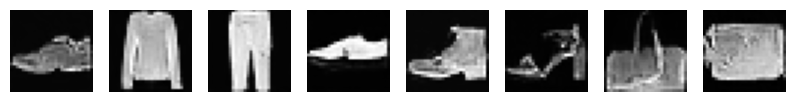

In [ ]:
# Función para visualizar el proceso de generación
def generate_images(model, scheduler, num_images=5):
    model.eval()
    
    # 1. Empezamos con ruido aleatorio puro (Gaussian Noise)
    # Shape: (num_images, 1, 28, 28)
    sample = torch.randn(num_images, 1, IMG_SIZE, IMG_SIZE).to(device)
    
    print("Generando imágenes...")
    
    # 2. Bucle de Denoising (vamos hacia atrás: 999 -> 0)
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        
        # Desactivamos gradientes para ahorrar memoria
        with torch.no_grad():
            # El modelo predice el residuo de ruido
            model_output = model(sample, t).sample

        # El scheduler calcula el paso: x_{t-1} = x_t - ruido_predicho + algo_de_azar
        sample = scheduler.step(model_output, t, sample).prev_sample

    # 3. Procesar para visualizar
    sample = (sample / 2 + 0.5).clamp(0, 1) # Des-normalizar
    sample = sample.cpu().permute(0, 2, 3, 1).numpy()
    
    # Mostrar
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(sample[i], cmap="gray")
        plt.axis('off')
    plt.show()

# ¡Llamamos a la función!
generate_images(model, noise_scheduler, num_images=8)

Si el modelo está bien entrenado, verás aparecer formas que parecen camisetas, pantalones o botas. Con solo 3 épocas, las imágenes pueden ser un poco borrosas o abstractas. Si quieres más definición, sube EPOCHS = 10 o más.

En esta pequeña práctica has puesto en funcionamiento un primer modelo de difusión básico. Por supuesto, los modelos grandes como stable diffusion, midjourney, dall-e, nano-banana, z-image, tienen una arquitectura mucho más avanzada, pero los conceptos básicos aquí vistos siguen siendo los mismos.